In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import time
import os
from tqdm import tqdm
# import tensorflow as tf
# import tf.keras as keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
from keras import metrics

from DataPreparation.dataset_preparation import get_LANL_dataset
from Utilities.evaluation_utils import save_submission

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
data_dir = '../Data/LANL_Earthquake_prediction/'
validation_split = 0.2
numpy = True
normalize = True
verbose= True

In [3]:
data, X_train_moments = get_LANL_dataset(data_dir, validation_split, numpy, normalize)
if numpy:
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    test_dict = data['test_dict']
    if verbose:
        print('')
        print('----- Dataset Description -----')
        print('X_train size: %d' % len(X_train))
        print('X_val size: %d' % len(X_val))
        print('test_dict size: %d' % len(test_dict))
        print('-------------------------------')
else:
    train_df = data['train_df']
    val_df = data['val_df']
    test_dict = data['test_dict']
    if verbose:
        print('')
        print('----- Dataset Description -----')
        print('train_df:')
        print(train_df.count().compute())
        print('-----------')
        print('val_df:')
        print(val_df.count().compute())
        print('-----------')
        print('test_dict size: %d' % len(test_dict))
        print('-------------------------------')

Dask dataframes loaded.
Preprocessing...
Converting to numpy...
Done.

----- Dataset Description -----
X_train size: 503316384
X_val size: 125829096
test_dict size: 2624
-------------------------------


In [4]:
X_merged = np.hstack([X_train, X_val])
y_merged = np.hstack([y_train, y_val])

seq_len = 150000
earthquake_ind = [0, 5656574, 50085878, 104677356,
                  138772453, 187641820, 218652630, 245829585,
                  307838917, 338276287, 375377848, 419368880,
                  461811623, 495800225, 528777115, 585568144,
                  621985673]
earthquake_ind = np.asarray(earthquake_ind)

In [5]:
len_train_total = 629145480

In [6]:
from random import randint, choice
val_eq_ind = np.hstack([earthquake_ind[-4:], len_train_total])
val_eq_ind -= np.min(val_eq_ind)
train_eq_ind = earthquake_ind[:-4]

val_slicing_ranges = [(val_eq_ind[i], (val_eq_ind[i+1]-seq_len)) for i in range(len(val_eq_ind)-1)]
train_slicing_ranges = [(train_eq_ind[i], (train_eq_ind[i+1]-seq_len)) for i in range(len(train_eq_ind)-1)]

def uniform_from_slices(slices, n):
    out = []
    for _ in range(n):
        r = choice(slices)
        out.append(randint(*r))
    return out
        
# print(uniform_from_slices(val_slicing_ranges, 5))
# print(uniform_from_slices(train_slicing_ranges, 5))

In [7]:
X_train = X_merged[:earthquake_ind[-4]]
X_val = X_merged[earthquake_ind[-4]:]

y_train = y_merged[:earthquake_ind[-4]]
y_val = y_merged[earthquake_ind[-4]:]

In [8]:
# print(val_slicing_ranges)
# print(len(X_val))
# print(train_slicing_ranges)
# print(len(X_train))

In [9]:
train_sample_size = 40000 # 3355
train_sample_ind = uniform_from_slices(train_slicing_ranges, train_sample_size)

val_sample_size = 1000 # 838
val_sample_ind = uniform_from_slices(val_slicing_ranges, val_sample_size)

In [10]:
# print(train_sample_ind[:20])

In [11]:
def sample_sequences(x, y, indices, seq_len):
    num_samples = len(indices)
    x_ = np.zeros((num_samples, seq_len))
    y_ = np.zeros(num_samples)
    for i, ind in enumerate(indices):
        x_[i, :] = x[ind:ind+seq_len]
        y_[i] = y[ind+seq_len-1]
    return x_, y_

X_val_, y_val_ = sample_sequences(X_val, y_val, val_sample_ind, seq_len)
X_train_, y_train_ = sample_sequences(X_train, y_train, train_sample_ind, seq_len)

In [12]:
X_train = X_train_[:,:,None]
y_train = y_train_
# X_train = X_train[:int(np.floor(X_train.shape[0] / seq_len))*seq_len]
# y_train = y_train[:int(np.floor(y_train.shape[0] / seq_len))*seq_len]
# X_train= X_train.reshape((-1, seq_len, 1))
# print(X_train.shape)
# y_train = y_train[seq_len-1::seq_len]
# print(y_train.shape)

X_val = X_val_[:,:,None]
y_val = y_val_

In [ ]:
# del X_train_, y_train_
# del X_val_, y_val_
# del X_merged, y_merged

In [13]:
# print(np.random.choice(y_train, 20))
# print(y_train_[:20])
# print(X_train_.shape)

In [20]:
# # N_ROWS = 5e6
# # data_dir = '../Data/LANL_Earthquake_prediction/'

# # train = pd.read_csv(data_dir+'trainset/train_split_0.2.csv',        
# #                 #nrows= N_ROWS, 
# #                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
# # print('Train input completed')

# # X_train = train['acoustic_data']
# # y_train = train['time_to_failure']

# # del train
# # print(X_train.shape)
# # Cut training data
# rows = 150000
# X_train = X_train[:int(np.floor(X_train.shape[0] / rows))*rows]
# y_train = y_train[:int(np.floor(y_train.shape[0] / rows))*rows]
# X_train= X_train.reshape((-1, rows, 1))
# print(X_train.shape)

# y_train = y_train[rows-1::rows]
# print(y_train.shape)

# # Training/ Vaidation Split
# # X_train, X_val, y_train, y_val = train_test_split(X_train,
# #                                                 y_train,
# #                                                 test_size= 0.2,
# #                                                 random_state= 11)

(3355, 150000, 1)
(3355,)


In [15]:
# # N_ROWS = 5e6
# # data_dir = '../Data/LANL_Earthquake_prediction/'

# # val = pd.read_csv(data_dir+'trainset/validation_split_0.2.csv',        
# #                 #nrows= N_ROWS, 
# #                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
# # print('Val input completed')

# # X_val = val['acoustic_data']
# # y_val = val['time_to_failure']

# # del val
# # print(X_val.shape)
# # Cut training data
# rows = 150000
# X_val = X_val[:int(np.floor(X_val.shape[0] / rows))*rows]
# y_val = y_val[:int(np.floor(y_val.shape[0] / rows))*rows]
# X_val= X_val.reshape((-1, rows, 1))
# y_val = y_val[rows-1::rows]
# print(X_val.shape)
# print(y_val.shape)

In [13]:
rows=seq_len

In [14]:
# Model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout
from keras.optimizers import adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [15]:
model = Sequential()

# Conv 1
model.add(Conv1D(32, 10, activation='relu', input_shape=(rows, 1)))
model.add(Conv1D(32, 10, activation='relu'))

# Max Pooling
#model.add(MaxPooling1D(100))

# Conv 3
model.add(Conv1D(64, 10, dilation_rate=1, padding='valid', activation='relu'))
model.add(Conv1D(64, 10, dilation_rate=2, padding='valid', activation='relu'))
model.add(Conv1D(64, 10, dilation_rate=4, padding='valid', activation='relu'))
model.add(Conv1D(64, 10, dilation_rate=8, padding='valid', activation='relu'))

# Average Pooling
model.add(GlobalAveragePooling1D())

model.add(Dense(16, kernel_initializer='normal',activation='relu'))
# Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=0,
                              mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5',
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=5,
                                   verbose=1,
                                   epsilon=1e-4,
                                   mode='min')

model.compile(loss='mean_absolute_error', optimizer= adam(lr=1e-4), metrics=['mean_absolute_error'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


D:\toolkits.win\anaconda3-5.2.0\envs\dlwin36\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 149991, 32)        352       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 149982, 32)        10272     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149973, 64)        20544     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 149955, 64)        41024     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 149919, 64)        41024     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 149847, 64)        41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
__________

In [16]:
model.fit(X_train, 
        y_train,
        batch_size= 16,
        epochs= 100, 
        validation_data= (X_val, y_val),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
        verbose=2
         )


y_pred = model.predict(X_val)

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 1000 samples
Epoch 1/100
 - 1453s - loss: 2.3950 - mean_absolute_error: 2.3950 - val_loss: 2.5682 - val_mean_absolute_error: 2.5682
Epoch 2/100
 - 1424s - loss: 2.0575 - mean_absolute_error: 2.0575 - val_loss: 2.3985 - val_mean_absolute_error: 2.3985
Epoch 3/100
 - 1422s - loss: 2.0496 - mean_absolute_error: 2.0496 - val_loss: 2.1413 - val_mean_absolute_error: 2.1413
Epoch 4/100
 - 1424s - loss: 2.0440 - mean_absolute_error: 2.0440 - val_loss: 2.1129 - val_mean_absolute_error: 2.1129
Epoch 5/100
 - 1424s - loss: 2.0416 - mean_absolute_error: 2.0416 - val_loss: 2.3240 - val_mean_absolute_error: 2.3240
Epoch 6/100
 - 1424s - loss: 2.0365 - mean_absolute_error: 2.0365 - val_loss: 2.0181 - val_mean_absolute_error: 2.0181
Epoch 7/100
 - 1424s - loss: 2.0346 - mean_absolute_error: 2.0346 - val_loss: 2.5232 - val_mean_absolute_error: 2.5232
Epoch 8/100


KeyboardInterrupt: 

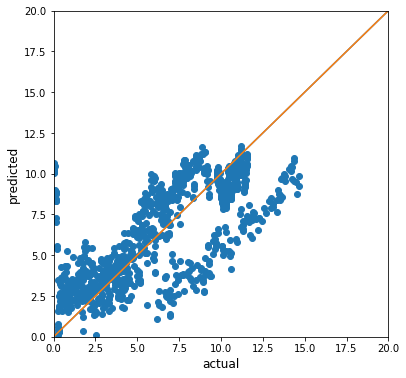

In [30]:
# Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [31]:
model.evaluate(X_val, y_val)

1000/1000 [==============================] - 12s 12ms/step


[1.9168879528045655, 1.9168879528045655]

In [22]:
# training Score
score = mean_absolute_error(y_val.flatten(), y_pred)
print(f'Score: {score:0.3f}')

NameError: name 'mean_absolute_error' is not defined

In [32]:
(X_train_mean, X_train_std) = X_train_moments

In [37]:
# Submission
submission = pd.read_csv(data_dir+'sample_submission.csv', index_col='seg_id')

X_test = []

for segment in tqdm(submission.index):
        seg = pd.read_csv(data_dir+'testset/' + segment + '.csv')
        x = pd.Series(seg['acoustic_data'].values)
        X_test.append(x)

X_test = (np.asarray(X_test) - X_train_mean)/ X_train_std
X_test = X_test.reshape((-1, 1))
print(X_test.shape)
X_test = X_test[:int(np.floor(X_test.shape[0] / rows))*rows]
X_test= X_test.reshape((-1, rows, 1))
print(X_test.shape)
submission['time_to_failure'] = model.predict(X_test)
submission.to_csv('submissions/sample_wavenet_submission_1.91.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 2624/2624 [00:53<00:00, 49.50it/s]


(393600000, 1)
(2624, 150000, 1)


In [ ]:
#You advanced 335 places on the leaderboard!

# Your submission scored 1.747, which is an improvement of your previous score of 2.737. Great job!